In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

from Triangle_BBH.Utils import ParamDict2ParamArr, ParamArr2ParamDict
from scipy.optimize import differential_evolution

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform
number of cpus = 12


## Load data

In [3]:
h5filename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5paramfilename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file:
    parameters = read_dict_from_h5(h5file["/"])
parameters.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
channel_names = list(data_dict["XYZ"].keys())
data_channels = []
for ch in channel_names: 
    data_channels.append(data_dict["XYZ"][ch])
data_channels = np.array(data_channels)
data_time = data_dict["time"]
dt = data_time[1] - data_time[0]

data_time.shape, data_channels.shape 

((6294349,), (3, 6294349))

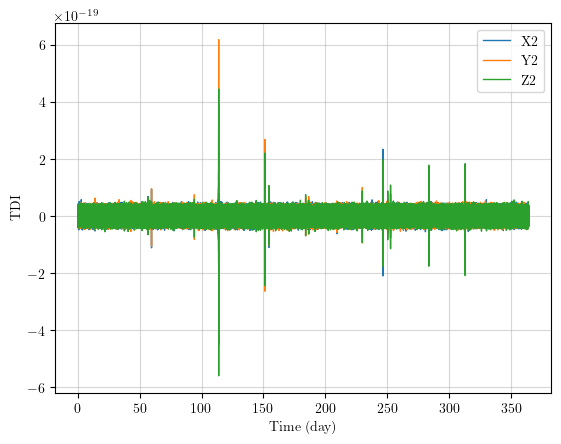

In [6]:
for ich, ch in enumerate(channel_names): 
    plt.plot(data_time/DAY, data_channels[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")
plt.grid(linestyle="-", which="major", alpha=0.5)
plt.grid(linestyle=":", which="minor", alpha=0.4)

## Slice data 

In [7]:
T_analyze = 3 * DAY 
T_pad_before = 1 * DAY 
T_pad_end = 1 * DAY 

In [8]:
# prior of tc: start_time -> end_time 
# data time: start_pad_time -> end_pad_time 
start_time = 250. * DAY 
start_pad_time = start_time - T_pad_before
end_time = start_time + T_analyze
end_pad_time = end_time + T_pad_end 

# slice data 
idx_slice = np.where((data_time>=start_pad_time)&(data_time<=end_pad_time))[0]
time_slice = data_time[idx_slice]
data_slice = data_channels[:, idx_slice]

time_slice.shape, data_slice.shape, time_slice[0]/DAY, time_slice[-1]/DAY 

((86401,), (3, 86401), 249.0, 254.0)

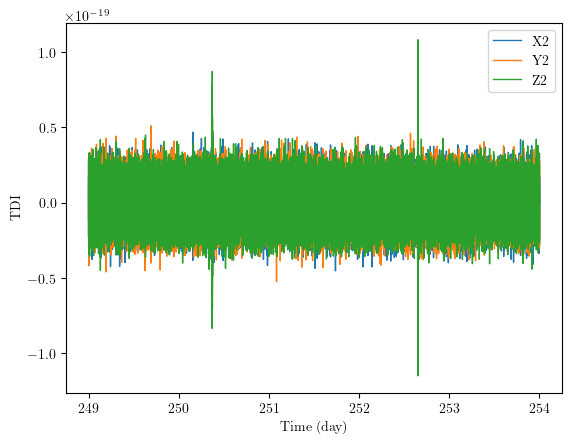

In [9]:
for ich, ch in enumerate(channel_names): 
    plt.plot(time_slice/DAY, data_slice[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

## Load truths for comparison 

In [10]:
# load source parameters for comparison 
mbhb_idx = np.where((parameters["coalescence_time"]*DAY >= start_time)&(parameters["coalescence_time"]*DAY <= end_time))[0]
mbhb_parameters = dict()
for k, v in parameters.items():
    mbhb_parameters[k] = v[mbhb_idx]
mbhb_parameters

{'chirp_mass': array([ 447336.54295195, 1453083.64878273]),
 'coalescence_phase': array([3.14236419, 2.90365985]),
 'coalescence_time': array([252.64926771, 250.37059516]),
 'inclination': array([1.54340257, 2.99740871]),
 'latitude': array([-1.3158673 ,  0.91362495]),
 'longitude': array([3.43915303, 0.77255799]),
 'luminosity_distance': array([ 69694.56098771, 131219.52472676]),
 'mass_ratio': array([0.99538133, 0.89814911]),
 'psi': array([2.96451666, 0.667554  ]),
 'spin_1z': array([0.65665 , 0.567929]),
 'spin_2z': array([-0.608346,  0.806169])}

## Search 

### 1st search 

In [ ]:
# load data 
data_td = data_slice[0].copy()
data_time = time_slice.copy()
dt = data_time[1] - data_time[0]

# fourier transform of data 
win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.05))
data_frequency, data_fd = FFT_window(data_td, fsample=1./dt, **win_args)
df = data_frequency[1] - data_frequency[0]

# remove null frequencies 
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 41):
    mask_idx = np.where(np.abs(data_frequency - i * 0.025) < 3e-4 * i)[0]
    mask[mask_idx] = False 
data_frequency = data_frequency[mask]
data_fd = data_fd[mask]
print("frequency-domain data shape:", data_fd.shape)

# calculate PSD at given arm length 
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
arms = dict()
for key in MOSA_labels: 
    arms[key] = float(orbit.LTTfunctions()[key](np.mean(data_time)))
# assumming noises are known 
PSDfunc = TDIPSDs()
PSDdata = PSDfunc.PSD_X2_unequal(data_frequency, arms)

# signal model 
mbhb_waveform_generator = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit,
    tcb_times=data_time.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="linear",
    complex_waveform_interp_order=3,
)

# snr as a function of parameters 
def rho_dl(params): 
    """ SNR with luminosity distance marginalized, params is 10-d """
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    try: 
        template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    except (RuntimeError, ValueError) as e: 
        print("error:", e)
        print("error parameters:", params_full)
        template_td = np.zeros_like(data_td)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    return d_h_inner / np.sqrt(h_h_inner)

def cost_function(params):
    """ costfunction = - SNR, params is 10-d """
    return -rho_dl(params)

# recover dl and convert other parameters 
def recover_params(params):
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    dl = h_h_inner / d_h_inner
    recovered_params = ParamArr2ParamDict(params_full)
    recovered_params["luminosity_distance"] = dl 
    return recovered_params

frequency-domain data shape: (41127,)


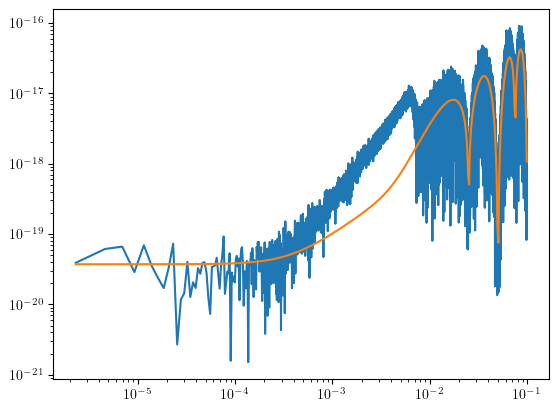

In [12]:
plt.loglog(data_frequency, np.abs(data_fd))
plt.loglog(data_frequency, np.sqrt(PSDdata / 2. / df))

In [13]:
maxiter=2000
# maxiter=10
popsize=20
tol=1e-6
atol=1e-2

bounds = [
    # (5., 6.5),
    (4., 7.),
    (0.1, 1.),
    (-0.99, 0.99),
    (-0.99, 0.99),
    (data_time[0]/DAY, data_time[-1]/DAY),
    (0, TWOPI), 
    (-1., 1.),
    (0, TWOPI), 
    (-1., 1.), 
    (0, PI),
]

result = differential_evolution(
    func=cost_function, 
    bounds=bounds,
    strategy='best1bin',    
    maxiter=maxiter,
    popsize=popsize,
    tol=tol,
    atol=atol, 
    mutation=(0.5, 1),    
    recombination=0.9, 
    workers=-1, 
    updating='deferred', 
    seed=114514
)

result

/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2473396650.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)


error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument
error: Internal function call failed: Invalid argument


/Users/taijidatacenter/workspace/Triangle-Simulator/Triangle/GW.py:606: RuntimeWarning: divide by zero encountered in scalar power
  f_lower = 1.75e-5 * (Mc / 1e6) ** (-5.0 / 8.0) * (Tobs / 10.0) ** (-3.0 / 8.0)
XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2473396650.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
XLAL Error - Starting frequency is above ringdown freq

             message: Optimization terminated successfully.
             success: True
                 fun: -533.0048505121708
                   x: [ 6.157e+00  7.263e-01  8.102e-01  3.661e-01
                        2.504e+02  2.273e+00 -6.350e-01  6.690e-01
                       -6.545e-01  1.849e+00]
                 nit: 633
                nfev: 126822
          population: [[ 6.157e+00  7.263e-01 ... -6.545e-01  1.849e+00]
                       [ 6.159e+00  7.402e-01 ... -6.556e-01  1.679e+00]
                       ...
                       [ 6.158e+00  7.249e-01 ... -6.445e-01  1.755e+00]
                       [ 6.157e+00  7.129e-01 ... -6.518e-01  1.989e+00]]
 population_energies: [-5.330e+02 -5.330e+02 ... -5.330e+02 -5.330e+02]

In [55]:
searched_params = [] 

searched_params.append(recover_params(result.x))
searched_params, np.array(ParamDict2ParamArr(searched_params[-1])) - np.array(ParamDict2ParamArr(mbhb_parameters)).T

([{'chirp_mass': 1435874.694581948,
   'mass_ratio': 0.7263257142756034,
   'spin_1z': 0.810160819005286,
   'spin_2z': 0.36611376522133926,
   'coalescence_time': 250.37119568422906,
   'coalescence_phase': 2.2728914085502385,
   'luminosity_distance': 152433.26562794184,
   'inclination': 2.258774327654888,
   'longitude': 0.668995268533858,
   'latitude': -0.7135113927237977,
   'psi': 1.848613883119352}],
 array([[ 5.06482165e-01, -2.69055611e-01,  1.53510819e-01,
          9.74459765e-01, -2.27807203e+00, -8.69472777e-01,
          3.39880867e-01, -6.62366752e-01, -2.77015776e+00,
          3.13188543e-01, -1.11590277e+00],
        [-5.17407409e-03, -1.71823396e-01,  2.42231819e-01,
         -4.40055235e-01,  6.00528828e-04, -6.30768440e-01,
          6.50812933e-02,  3.54647067e-01, -1.03562723e-01,
         -1.44621600e+00,  1.18105988e+00]]))

In [56]:
searched_signal_td = []
searched_signal_fd = []

tmp_td, _, _ = mbhb_response_generator(parameters=searched_params[-1], waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
_, tmp_fd = FFT_window(tmp_td, 1./dt, **win_args)
tmp_fd = tmp_fd[mask]

searched_signal_td.append(tmp_td)
searched_signal_fd.append(tmp_fd)

(250.34, 250.4)

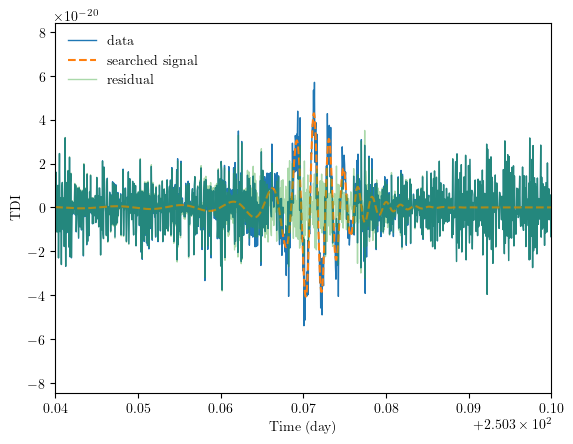

In [57]:
plt.plot(data_time / DAY, data_slice[0], linewidth=1, label="data")
plt.plot(data_time / DAY, searched_signal_td[-1], linestyle="--", label="searched signal")
plt.plot(data_time / DAY, data_slice[0] - searched_signal_td[-1], linewidth=1, alpha=0.4, label="residual")
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left", frameon=False)
plt.xlim(250.34, 250.4)

### 2nd search 

In [58]:
# load data 
data_td = data_slice[0] - np.sum(np.array(searched_signal_td), axis=0)

# fourier transform of data 
_, data_fd = FFT_window(data_td, fsample=1./dt, **win_args)

# remove null frequencies 
data_fd = data_fd[mask]
print("frequency-domain data shape:", data_fd.shape)

# snr as a function of parameters 
def rho_dl(params): 
    """ SNR with luminosity distance marginalized, params is 10-d """
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    try: 
        template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    except (RuntimeError, ValueError) as e: 
        print("error:", e)
        print("error parameters:", params_full)
        template_td = np.zeros_like(data_td)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    return d_h_inner / np.sqrt(h_h_inner)

def cost_function(params):
    """ costfunction = - SNR, params is 10-d """
    return -rho_dl(params)

# recover dl and convert other parameters 
def recover_params(params):
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    dl = h_h_inner / d_h_inner
    recovered_params = ParamArr2ParamDict(params_full)
    recovered_params["luminosity_distance"] = dl 
    return recovered_params

maxiter=2000
# maxiter=10
popsize=20
tol=1e-6
atol=1e-2

bounds = [
    # (5., 6.5),
    (4., 7.),
    (0.1, 1.),
    (-0.99, 0.99),
    (-0.99, 0.99),
    (data_time[0]/DAY, data_time[-1]/DAY),
    (0, TWOPI), 
    (-1., 1.),
    (0, TWOPI), 
    (-1., 1.), 
    (0, PI),
]

result = differential_evolution(
    func=cost_function, 
    bounds=bounds,
    strategy='best1bin',    
    maxiter=maxiter,
    popsize=popsize,
    tol=tol,
    atol=atol, 
    mutation=(0.5, 1),    
    recombination=0.9, 
    workers=-1, 
    updating='deferred', 
    seed=114514
)

result


frequency-domain data shape: (41127,)


/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)


error: Internal function call failed: Invalid argument
error parameters: [7.00000000e+00 1.00000000e-01 9.90000000e-01 9.90000000e-01
 2.49000000e+02 1.40727292e+00 0.00000000e+00 4.92484036e-01
 4.51499808e+00 7.84867984e-02 1.43468272e+00]
error: Internal function call failed: Invalid argument
error parameters: [6.99999999e+00 1.00000000e-01 9.90000000e-01 9.90000000e-01
 2.49000000e+02 1.40727292e+00 0.00000000e+00 4.92484036e-01
 4.51499808e+00 7.84867984e-02 1.43468272e+00]
error: Internal function call failed: Invalid argument
error parameters: [7.00000000e+00 1.00000010e-01 9.90000000e-01 9.90000000e-01
 2.49000000e+02 1.40727292e+00 0.00000000e+00 4.92484036e-01
 4.51499808e+00 7.84867984e-02 1.43468272e+00]
error: Internal function call failed: Invalid argument
error parameters: [7.00000000e+00 1.00000000e-01 9.89999990e-01 9.90000000e-01
 2.49000000e+02 1.40727292e+00 0.00000000e+00 4.92484036e-01
 4.51499808e+00 7.84867984e-02 1.43468272e+00]
error: Internal function call fa

/Users/taijidatacenter/workspace/Triangle-Simulator/Triangle/GW.py:606: RuntimeWarning: divide by zero encountered in scalar power
  f_lower = 1.75e-5 * (Mc / 1e6) ** (-5.0 / 8.0) * (Tobs / 10.0) ** (-3.0 / 8.0)
XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
XLAL Error - Starting frequency is above ringdown freq

             message: Optimization terminated successfully.
             success: True
                 fun: -114.19357546663485
                   x: [ 5.651e+00  7.986e-01  3.451e-01 -3.616e-01
                        2.527e+02  1.468e+00  4.993e-01  4.687e+00
                        6.437e-02  1.482e+00]
                 nit: 707
                nfev: 141622
          population: [[ 5.651e+00  7.986e-01 ...  6.437e-02  1.482e+00]
                       [ 5.651e+00  8.159e-01 ...  4.925e-02  1.518e+00]
                       ...
                       [ 5.651e+00  8.025e-01 ...  6.886e-02  1.314e+00]
                       [ 5.651e+00  7.975e-01 ...  1.922e-02  1.764e+00]]
 population_energies: [-1.142e+02 -1.142e+02 ... -1.142e+02 -1.142e+02]

In [59]:
searched_params.append(recover_params(result.x))
searched_params, np.array(ParamDict2ParamArr(searched_params[-1])) - np.array(ParamDict2ParamArr(mbhb_parameters)).T

([{'chirp_mass': 1435874.694581948,
   'mass_ratio': 0.7263257142756034,
   'spin_1z': 0.810160819005286,
   'spin_2z': 0.36611376522133926,
   'coalescence_time': 250.37119568422906,
   'coalescence_phase': 2.2728914085502385,
   'luminosity_distance': 152433.26562794184,
   'inclination': 2.258774327654888,
   'longitude': 0.668995268533858,
   'latitude': -0.7135113927237977,
   'psi': 1.848613883119352},
  {'chirp_mass': 447756.39314149815,
   'mass_ratio': 0.7985550166997256,
   'spin_1z': 0.34512980699714574,
   'spin_2z': -0.36161036139112934,
   'coalescence_time': 252.65306284512,
   'coalescence_phase': 1.4683340769314683,
   'luminosity_distance': 148113.50261901275,
   'inclination': 1.0480413356541978,
   'longitude': 4.686847509911027,
   'latitude': 0.06441325268228562,
   'psi': 1.481669919620156}],
 array([[ 4.07418328e-04, -1.96826309e-01, -3.11520193e-01,
          2.46735639e-01,  3.79513155e-03, -1.67403011e+00,
          3.27395766e-01,  4.71878755e-01,  1.2476944

In [60]:
tmp_td, _, _ = mbhb_response_generator(parameters=searched_params[-1], waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
_, tmp_fd = FFT_window(tmp_td, 1./dt, **win_args)
tmp_fd = tmp_fd[mask]

searched_signal_td.append(tmp_td)
searched_signal_fd.append(tmp_fd)

(252.64, 252.66)

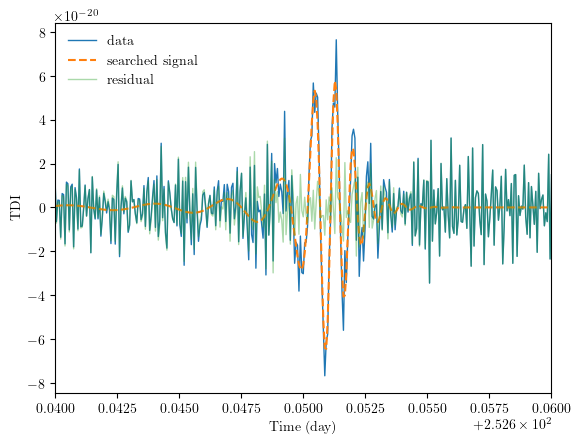

In [70]:
plt.plot(data_time / DAY, data_slice[0], linewidth=1, label="data")
plt.plot(data_time / DAY, np.sum(np.array(searched_signal_td), axis=0), linestyle="--", label="searched signal")
plt.plot(data_time / DAY, data_slice[0] - np.sum(np.array(searched_signal_td), axis=0), linewidth=1, alpha=0.4, label="residual")
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left", frameon=False)
plt.xlim(252.64, 252.66)

### 3rd search 

In [71]:
# load data 
data_td = data_slice[0] - np.sum(np.array(searched_signal_td), axis=0)

# fourier transform of data 
_, data_fd = FFT_window(data_td, fsample=1./dt, **win_args)

# remove null frequencies 
data_fd = data_fd[mask]
print("frequency-domain data shape:", data_fd.shape)

# snr as a function of parameters 
def rho_dl(params): 
    """ SNR with luminosity distance marginalized, params is 10-d """
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    try: 
        template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    except (RuntimeError, ValueError) as e: 
        print("error:", e)
        print("error parameters:", params_full)
        template_td = np.zeros_like(data_td)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    return d_h_inner / np.sqrt(h_h_inner)

def cost_function(params):
    """ costfunction = - SNR, params is 10-d """
    return -rho_dl(params)

# recover dl and convert other parameters 
def recover_params(params):
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    dl = h_h_inner / d_h_inner
    recovered_params = ParamArr2ParamDict(params_full)
    recovered_params["luminosity_distance"] = dl 
    return recovered_params

maxiter=2000
# maxiter=10
popsize=20
tol=1e-6
atol=1e-2

bounds = [
    # (5., 6.5),
    (4., 7.),
    (0.1, 1.),
    (-0.99, 0.99),
    (-0.99, 0.99),
    (data_time[0]/DAY, data_time[-1]/DAY),
    (0, TWOPI), 
    (-1., 1.),
    (0, TWOPI), 
    (-1., 1.), 
    (0, PI),
]

result = differential_evolution(
    func=cost_function, 
    bounds=bounds,
    strategy='best1bin',    
    maxiter=maxiter,
    popsize=popsize,
    tol=tol,
    atol=atol, 
    mutation=(0.5, 1),    
    recombination=0.9, 
    workers=-1, 
    updating='deferred', 
    seed=114514
)

result


frequency-domain data shape: (41127,)


XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument


error: Internal function call failed: Invalid argument
error parameters: [ 6.91940007e+00  1.30032954e-01 -3.99588028e-01  1.53491572e-01
  2.49011302e+02  3.25943776e+00  0.00000000e+00 -5.38174225e-01
  5.35184475e+00  3.99648046e-01  2.55177941e-01]


/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument


error: Internal function call failed: Invalid argument
error parameters: [6.95859924e+00 3.88724009e-01 6.91376063e-02 2.41836091e-01
 2.49001327e+02 1.99925829e+00 0.00000000e+00 6.66432428e-01
 6.26237747e+00 8.80642285e-02 2.09332495e+00]


XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument


error: Internal function call failed: Invalid argument
error parameters: [ 6.50126230e+00  5.11573161e-01 -9.67623817e-02 -4.25007709e-02
  2.49000468e+02  1.92022739e+00  0.00000000e+00  9.95333509e-02
  1.23468770e+00  1.14260136e-01  2.30818737e+00]


/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)


error: Internal function call failed: Invalid argument
error parameters: [ 4.00000000e+00  1.00000000e-01 -9.90000000e-01 -9.90000000e-01
  2.49000000e+02  3.42325267e+00  0.00000000e+00  5.13154816e-01
  6.28318531e+00 -1.00000000e+00  7.10126191e-01]
error: Internal function call failed: Invalid argument
error parameters: [ 4.00000001e+00  1.00000000e-01 -9.90000000e-01 -9.90000000e-01
  2.49000000e+02  3.42325267e+00  0.00000000e+00  5.13154816e-01
  6.28318531e+00 -1.00000000e+00  7.10126191e-01]
error: Internal function call failed: Invalid argument
error parameters: [ 4.00000000e+00  1.00000010e-01 -9.90000000e-01 -9.90000000e-01
  2.49000000e+02  3.42325267e+00  0.00000000e+00  5.13154816e-01
  6.28318531e+00 -1.00000000e+00  7.10126191e-01]
error: Internal function call failed: Invalid argument
error parameters: [ 4.00000000e+00  1.00000000e-01 -9.89999990e-01 -9.90000000e-01
  2.49000000e+02  3.42325267e+00  0.00000000e+00  5.13154816e-01
  6.28318531e+00 -1.00000000e+00  7.10

/Users/taijidatacenter/workspace/Triangle-Simulator/Triangle/GW.py:606: RuntimeWarning: divide by zero encountered in scalar power
  f_lower = 1.75e-5 * (Mc / 1e6) ** (-5.0 / 8.0) * (Tobs / 10.0) ** (-3.0 / 8.0)
XLAL Error - Starting frequency is above ringdown frequency!
XLAL Error - XLALSimIMRSpinAlignedEOBModes (LALSimIMRSpinAlignedEOB.c:1275): Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveformAll (LALSimIMRSpinAlignedEOB.c:3912): Internal function call failed: Invalid argument
XLAL Error - XLALSimIMRSpinAlignedEOBWaveform (LALSimIMRSpinAlignedEOB.c:783): Internal function call failed: Invalid argument
XLAL Error - XLALSimInspiralChooseTDWaveform_legacy (LALSimInspiralGeneratorLegacy.c:1275): Internal function call failed: Invalid argument
/var/folders/_f/d29qj88911xdzjc9ffs55hph0000gn/T/ipykernel_2429/2647722624.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return d_h_inner / np.sqrt(h_h_inner)
XLAL Error - Starting frequency is above ringdown freq

             message: Optimization terminated successfully.
             success: True
                 fun: -17.14692221943876
                   x: [ 6.187e+00  4.983e-01  8.237e-01  9.651e-01
                        2.504e+02  3.553e+00  7.167e-01  3.214e+00
                       -7.666e-01  8.328e-01]
                 nit: 1091
                nfev: 218422
          population: [[ 6.187e+00  4.983e-01 ... -7.666e-01  8.328e-01]
                       [ 6.186e+00  4.943e-01 ... -7.667e-01  8.212e-01]
                       ...
                       [ 6.187e+00  4.950e-01 ... -7.665e-01  8.269e-01]
                       [ 6.187e+00  4.985e-01 ... -7.675e-01  7.432e-01]]
 population_energies: [-1.715e+01 -1.714e+01 ... -1.712e+01 -1.713e+01]

In [77]:
if result.success and -result.fun > 20.:
    print("new mbhb detected.")
    searched_params.append(recover_params(result.x))
searched_params, np.array(ParamDict2ParamArr(searched_params[-1])) - np.array(ParamDict2ParamArr(mbhb_parameters)).T

([{'chirp_mass': 1435874.694581948,
   'mass_ratio': 0.7263257142756034,
   'spin_1z': 0.810160819005286,
   'spin_2z': 0.36611376522133926,
   'coalescence_time': 250.37119568422906,
   'coalescence_phase': 2.2728914085502385,
   'luminosity_distance': 152433.26562794184,
   'inclination': 2.258774327654888,
   'longitude': 0.668995268533858,
   'latitude': -0.7135113927237977,
   'psi': 1.848613883119352},
  {'chirp_mass': 447756.39314149815,
   'mass_ratio': 0.7985550166997256,
   'spin_1z': 0.34512980699714574,
   'spin_2z': -0.36161036139112934,
   'coalescence_time': 252.65306284512,
   'coalescence_phase': 1.4683340769314683,
   'luminosity_distance': 148113.50261901275,
   'inclination': 1.0480413356541978,
   'longitude': 4.686847509911027,
   'latitude': 0.06441325268228562,
   'psi': 1.481669919620156}],
 array([[ 4.07418328e-04, -1.96826309e-01, -3.11520193e-01,
          2.46735639e-01,  3.79513155e-03, -1.67403011e+00,
          3.27395766e-01,  4.71878755e-01,  1.2476944

In [78]:
tmp_td, _, _ = mbhb_response_generator(parameters=searched_params[-1], waveform_generator=mbhb_waveform_generator, optimal_combination=False, complex_waveform=True)
_, tmp_fd = FFT_window(tmp_td, 1./dt, **win_args)
tmp_fd = tmp_fd[mask]

searched_signal_td.append(tmp_td)
searched_signal_fd.append(tmp_fd)

(252.64, 252.66)

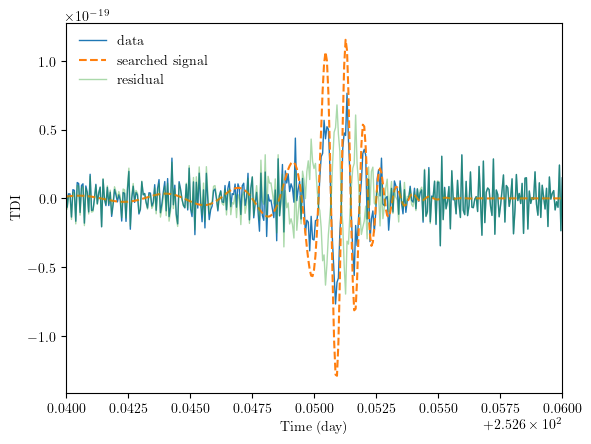

In [ ]:
plt.plot(data_time / DAY, data_slice[0], linewidth=1, label="data")
plt.plot(data_time / DAY, np.sum(np.array(searched_signal_td), axis=0), linestyle="--", label="searched signal")
plt.plot(data_time / DAY, data_slice[0] - np.sum(np.array(searched_signal_td), axis=0), linewidth=1, alpha=0.4, label="residual")
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left", frameon=False)
# plt.xlim(252.64, 252.66)

In [ ]:



def get_all_SSB_modes(params, orbit, orbit_time): 
    lS, bS, pS = params["longitude"], params["latitude"], params["psi"]
    iota = params["inclination"]
    
    # to detector frame 
    lD, bD, pD = SSB2Detector(lS, bS, pS, orbit, orbit_time)
    lDs = np.ones(8) * lD
    bDs = np.ones(8) * bD 
    pDs = np.ones(8) * pD 
    iotas = np.ones(8) * iota 
    
    # reflect 
    bDs[4:] *= -1. 
    pDs[4:] = PI - pDs[4:]
    iotas[4:] = PI - iotas[4:]
    
    # transformation 
    lDs[:4] += np.arange(4) * PI / 2.
    pDs[:4] += np.arange(4) * PI / 2.
    lDs[4:] += np.arange(4) * PI / 2.
    pDs[4:] += np.arange(4) * PI / 2.
    lDs = lDs%TWOPI
    pDs = pDs%PI 
    
    # back to SSB 
    lSs = np.zeros(8)
    bSs = np.zeros(8)
    pSs = np.zeros(8)
    for i in range(8):
        lSs[i], bSs[i], pSs[i] = Detector2SSB(lDs[i], bDs[i], pDs[i], orbit, orbit_time)
    
    # full parameters 
    params_arr = [] 
    for i in range(8):
        tmp = params.copy() 
        tmp["longitude"] = lSs[i]
        tmp["latitude"] = bSs[i]
        tmp["psi"] = pSs[i]
        tmp["inclination"] = iotas[i]
        params_arr.append(tmp)
    return params_arr
    

In [185]:
lD, bD, pD = SSB2Detector(searched_params[0]["longitude"], searched_params[0]["latitude"], searched_params[0]["psi"], orbit, searched_params[0]["coalescence_time"] * DAY)
lS, bS, pS = Detector2SSB(lD, bD, pD, orbit, searched_params[0]["coalescence_time"] * DAY)
lS, bS, pS, searched_params[0]["longitude"], searched_params[0]["latitude"], searched_params[0]["psi"]

(0.6689952685338578,
 -0.7135113927237979,
 1.8486138831193517,
 0.668995268533858,
 -0.7135113927237977,
 1.848613883119352)

In [186]:
true_params = []
for i in range(len(mbhb_parameters["chirp_mass"])):
    tmp = dict()
    for k, v in mbhb_parameters.items():
        tmp[k] = v[i]
    true_params.append(tmp)
true_params

[{'chirp_mass': 447336.54295195045,
  'coalescence_phase': 3.1423641851170796,
  'coalescence_time': 252.64926771356616,
  'inclination': 1.5434025721786673,
  'latitude': -1.3158673036020687,
  'longitude': 3.439153025137468,
  'luminosity_distance': 69694.5609877081,
  'mass_ratio': 0.9953813254672175,
  'psi': 2.964516655054327,
  'spin_1z': 0.65665,
  'spin_2z': -0.608346},
 {'chirp_mass': 1453083.6487827345,
  'coalescence_phase': 2.9036598481945135,
  'coalescence_time': 250.3705951554008,
  'inclination': 2.997408711184009,
  'latitude': 0.9136249539516011,
  'longitude': 0.7725579916759285,
  'luminosity_distance': 131219.52472675717,
  'mass_ratio': 0.8981491101776676,
  'psi': 0.6675539981251641,
  'spin_1z': 0.567929,
  'spin_2z': 0.806169}]

In [187]:
searched_params[0], true_params[1]

({'chirp_mass': 1435874.694581948,
  'mass_ratio': 0.7263257142756034,
  'spin_1z': 0.810160819005286,
  'spin_2z': 0.36611376522133926,
  'coalescence_time': 250.37119568422906,
  'coalescence_phase': 2.2728914085502385,
  'luminosity_distance': 152433.26562794184,
  'inclination': 2.258774327654888,
  'longitude': 0.668995268533858,
  'latitude': -0.7135113927237977,
  'psi': 1.848613883119352},
 {'chirp_mass': 1453083.6487827345,
  'coalescence_phase': 2.9036598481945135,
  'coalescence_time': 250.3705951554008,
  'inclination': 2.997408711184009,
  'latitude': 0.9136249539516011,
  'longitude': 0.7725579916759285,
  'luminosity_distance': 131219.52472675717,
  'mass_ratio': 0.8981491101776676,
  'psi': 0.6675539981251641,
  'spin_1z': 0.567929,
  'spin_2z': 0.806169})